## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [24]:
%load_ext autoreload
%autoreload 2
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
#from denoiser import Denoiser

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [19]:
hparams = create_hparams()
hparams.sampling_rate = 22050

{'age_num': 4,
 'attention_dim': 128,
 'attention_location_kernel_size': 31,
 'attention_location_n_filters': 32,
 'attention_rnn_dim': 1024,
 'batch_size': 8,
 'contents_switch_prob': 0.5,
 'cudnn_benchmark': False,
 'cudnn_enabled': True,
 'data': ['KETTS_male', 'KETTS_female', 'KNTTS', 'ETRI', 'KETTS76'],
 'dbroot': '',
 'decoder_rnn_dim': 1024,
 'dist_backend': 'nccl',
 'dist_url': 'tcp://localhost:54321',
 'distributed_run': False,
 'dynamic_loss_scaling': True,
 'emotion_num': 7,
 'encoder_embedding_dim': 512,
 'encoder_kernel_size': 5,
 'encoder_n_convolutions': 3,
 'epochs': 500,
 'filter_length': 2048,
 'fp16_run': False,
 'gate_threshold': 0.5,
 'gender_num': 2,
 'grad_clip_thresh': 1.0,
 'hop_length': 276,
 'ignore_layers': ['embedding.weight'],
 'iters_per_checkpoint': 1000,
 'learning_rate': 0.001,
 'load_mel_from_disk': False,
 'mask_padding': True,
 'max_decoder_steps': 1000,
 'max_wav_value': 32768.0,
 'mel_fmax': 8000.0,
 'mel_fmin': 0.0,
 'n_frames_per_step': 1,
 'n_m

#### Load model from checkpoint

In [20]:
checkpoint_path = "./result/2009211253KST-contents-0.0/checkpoint_33000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [ ]:
waveglow_path = 'waveglow_256channels.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
#denoiser = Denoiser(waveglow)

#### Prepare text input

In [31]:
text = "안녕하세요. 저는 감정을 담아 말하는 음성합성기에요."
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Prepare Mel for style

In [28]:
import pickle
mel_path = '/data1/thkim/data/KETTS/30m_bin_22050/neu_00970.mel'
style_mel = pickle.load(open(mel_path, 'rb'))['mel']
style_mel = torch.from_numpy(style_mel).unsqueeze(0).cuda().half()
style_mel.shape

torch.Size([1, 224, 80])

#### Decode text input and plot results

Warning! Reached max decoder steps


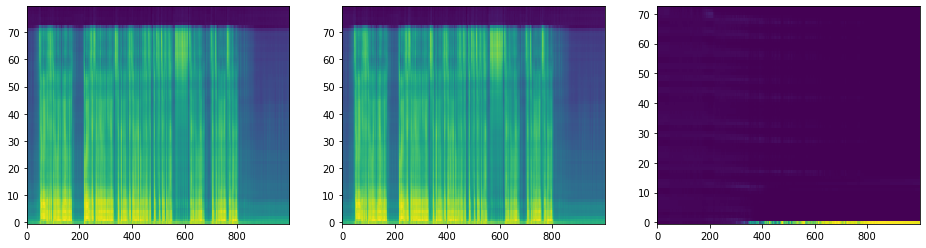

In [33]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence, style_mel)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [ ]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [ ]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 